In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

from collections import Counter


pd.set_option('display.max_columns', None)

colors_ = sns.color_palette('viridis', 15)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

In [2]:
class MyCounter(Counter):
    def __str__(self):
        return "\n".join('{}: {}'.format(k, v) for k, v in sorted(self.items()))



# <center>Cornerstone for Interpretation</center>

In [3]:
group1 = pd.read_csv(path+"id_vs_frequency_decreasing_ds.csv")
group1 = group1[group1.frequency > 0] # otherwise alpha-R ~ 1
group2 = pd.read_csv(path+"IDs/alpha_one/R_ids_alpha_0.9996.csv")
group3 = pd.read_csv(path+"IDs/alpha_two/R_ids_alpha_1.9930.csv")

DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False)
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

DB2 = pd.read_csv(path+"DB2P8.csv")

# There are shots missing in DB5 from DB2P8
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

### Categorical Data | Preprocessing

In [4]:
TOK_characteristics = ["DIVNAME","WALMAT","DIVMAT","LIMMAT"]
categorical = ["PREMAG","HYBRID","CONFIG","ELMTYPE",
               "ICSCHEME","AUXHEAT","EVAP"] + TOK_characteristics 

DB5[categorical] = DB5[categorical].fillna('UNKNOWN')
DB5["DIVNAME"]   = DB5["DIVNAME"].str.replace("NONAME","UNKNOWN",regex=False)

DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("CC","C",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI1","TI12",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI2","TI12",regex=False)

DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-I)|(DV-IPRE)|(DV-IPOST)",
                                            "DV-I",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-II)|(DV-IIc)|(DV-II-C)|(DV-IIb)|(DV-IIc)|(DV-IId)|(DV-IId)",
                                            "DV-II",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(MARK0)|(MARKI)|(MARKIIA)|(MARKGB)|(MARKGBSR)|"+
                                            "(MARKIA)|(MARKIAP)|(MARKSR)|(MARKA)|(MARKP)",
                                            "MARK",regex=True)

DB5["ICSCHEME"]   = DB5["ICSCHEME"].str.replace("OFF","NONE",regex=False)

DB5["EVAP"] = DB5["EVAP"].str.replace("CARBH","C-H",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("CARB","C",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("BOROC","C-BO",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("(BOROA)|(BOROB)|(BOROX)|(BOR)","BO",regex=True)
#DB5["EVAP"] = DB5["EVAP"].str.replace("DECABOA","C",regex=True)

### Making sure datas represent correct alpha-R

In [5]:
data1 = DB5[ DB5.id.isin(group1.id.values)] # alpha_R -- 0.6558 --> when considering DB2 for calculation
data2 = DB5[~DB5.id.isin(group1.id.values)] # alpha_R -- 2.1638 --> when considering DB2 for calculation
data2 = data2[~data2.id.isin(DB2.id.values)]# Removing DB2, because most of these shots have missing info

In [6]:
def get_regression(_R, withDB2=False):
    """
    ASSUMING DATA IS ***NOT*** GIVEN IN LOG-SCALE
    """
    if withDB2:
        data = _R.copy()
    else:     
        data = pd.concat([DB2, _R],
                         axis=0, 
                         ignore_index=True
                        )
    Y_ = data[["TAUTH"]].apply(np.log).to_numpy()
    # Adding a column for the intercept
    _df = data[coeffs].apply(np.abs).apply(np.log)
    _df.insert(
        loc = 0, 
        column = "intercept", 
        value = np.ones(len(_df))
    )
    X_ = _df.to_numpy()
    n_, p_ = X_.shape
    model = sm.OLS(Y_,X_)
    regression = model.fit()
    return data, regression, (n_,p_)

d_, r_, np_ = get_regression(data2, withDB2=False)

In [7]:
# Needed for Improved Visualization in Plots

hue_order_ICSCHEME = dict(zip(sorted(data1["ICSCHEME"].unique()), colors_[:len(data1["ICSCHEME"].unique())]))
hue_order_ELMTYPE  = dict(zip(sorted(data1["ELMTYPE"].unique()), colors_[:len(data1["ELMTYPE"].unique())]))
hue_order_HYBRID   = dict(zip(sorted(data1["HYBRID"].unique()), colors_[:len(data1["HYBRID"].unique())]))
hue_order_AUXHEAT  = dict(zip(sorted(data1["AUXHEAT"].unique()), colors_[:len(data1["AUXHEAT"].unique())]))
hue_order_DIVMAT   = dict(zip(sorted(data1["DIVMAT"].unique()), colors_[:len(data1["DIVMAT"].unique())]))
hue_order_WALMAT   = dict(zip(sorted(data1["WALMAT"].unique()), colors_[:len(data1["WALMAT"].unique())]))
hue_order_EVAP     = dict(zip(sorted(data1["EVAP"].unique()), colors_[:len(data1["EVAP"].unique())]))


# <center>General Description per Group</center>

In [8]:
## GROUP 1 -- Decreasing alpha-R the most
print(f"GROUP 1 | size = {len(data1)}")
print(f"Missing Tokamaks: {DB5[~DB5.TOK.isin(data1.TOK.unique())]['TOK'].unique()}")
print(f"Present Tokamaks: {data1.TOK.unique()}")
print("\n")
print(f"ELMTYPE\n{MyCounter(data1['ELMTYPE'])}")
print("\n")
print(f"PHASE\n{MyCounter(data1['PHASE'])}")

GROUP 1 | size = 1486
Missing Tokamaks: ['ASDEX' 'COMPASS' 'JFT2M' 'PBXM' 'PDX' 'TCV' 'TDEV' 'TFTR']
Present Tokamaks: ['AUG' 'AUGW' 'CMOD' 'D3D' 'JET' 'JETILW' 'JT60U' 'MAST' 'NSTX' 'START']


ELMTYPE
TYPE-1+2: 12
TYPE-1+5: 7
TYPE-I: 1023
TYPE-II: 100
TYPE-III: 148
TYPE-RF: 5
TYPE-V: 31
UNKNOWN: 160


PHASE
HGELM: 875
HGELMH: 262
HSELM: 326
HSELMH: 23


In [9]:
## GROUP 2 -- Decreasing alpha-R, but not so much
print(f"GROUP 2 | size = {len(data2)}")
print(f"Missing Tokamaks: {DB5[~DB5.TOK.isin(data2.TOK.unique())]['TOK'].unique()}")
print(f"Present Tokamaks: {data2.TOK.unique()}")
print("\n")
print(f"ELMTYPE\n{MyCounter(data2['ELMTYPE'])}")
print("\n")
print(f"PHASE\n{MyCounter(data2['PHASE'])}")

GROUP 2 | size = 3456
Missing Tokamaks: ['ASDEX' 'PBXM' 'PDX']
Present Tokamaks: ['AUG' 'AUGW' 'CMOD' 'COMPASS' 'D3D' 'JET' 'JETILW' 'JFT2M' 'JT60U' 'MAST'
 'NSTX' 'START' 'TCV' 'TDEV' 'TFTR']


ELMTYPE
TYPE-1+2: 20
TYPE-1+5: 13
TYPE-I: 2685
TYPE-II: 186
TYPE-III: 291
TYPE-RF: 25
TYPE-V: 34
UNKNOWN: 202


PHASE
HGELM: 2012
HGELMH: 615
HSELM: 774
HSELMH: 55


# <center>Heating Analysis</center>

**VARIABLES**

* `PECRH`: ECRH power absorbed by the plasma
* `PICRH`: iCRH power absorbed by the plasma
* `ICSCHEME`: ICRH heating scheme
* `AUXHEAT`: Type of auxiliary heating
* `ENBI`: Neutral beam energy weighted by power

In [10]:
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT","ENBI"]

### Group 1 | New points in DB5 that are decreasing alpha-R | $\alpha_R \sim 0.6$



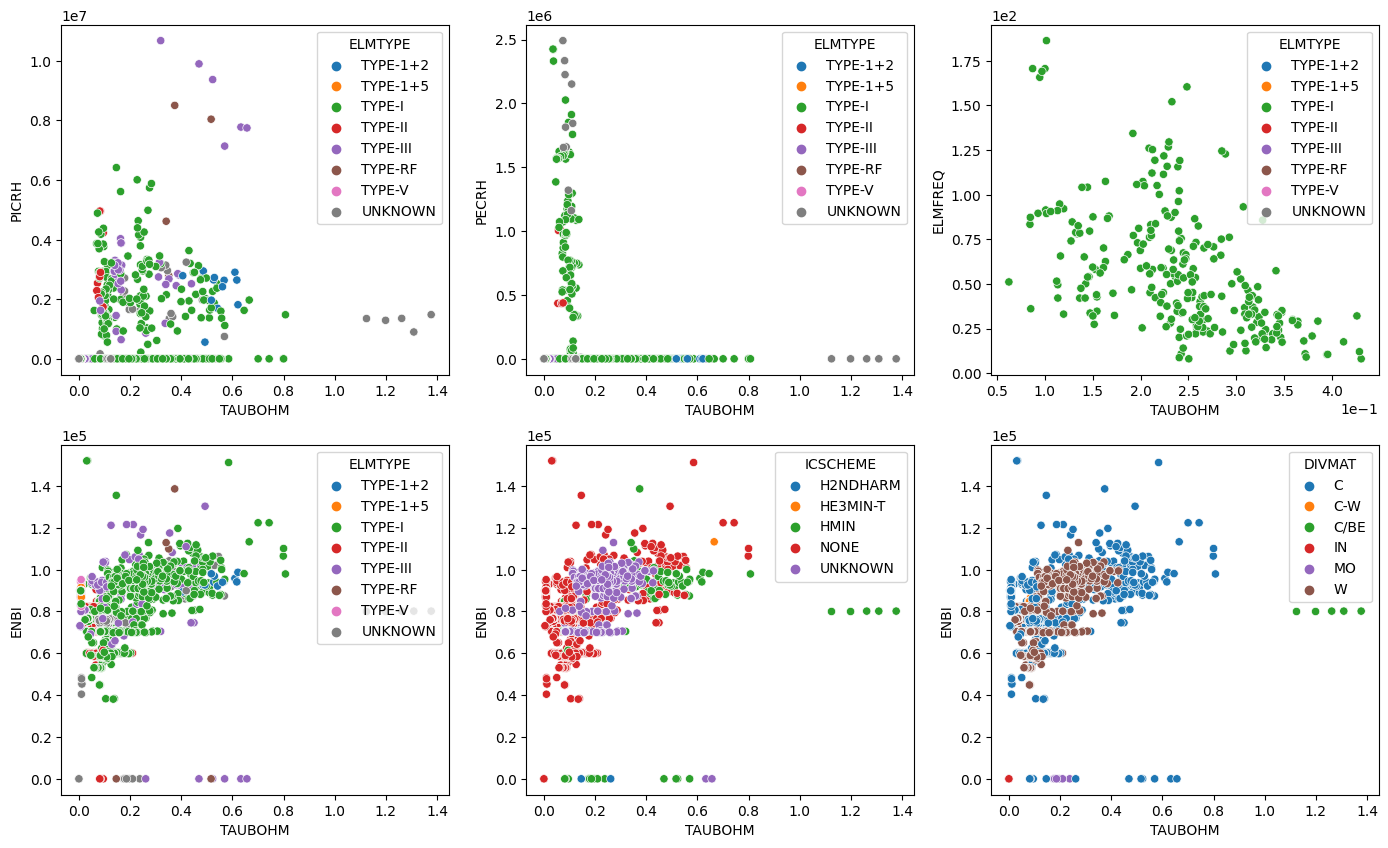

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data1.copy()

sns.scatterplot(data=data_, x="TAUBOHM", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUBOHM", y="PECRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUBOHM", y="ELMFREQ", hue="ELMTYPE" ,hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUBOHM", y="ENBI",hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUBOHM", y="ENBI",hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUBOHM", y="ENBI",hue="DIVMAT" ,hue_order=hue_order_DIVMAT, ax=axs[1,2]);

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));


### Group 2 |  $\alpha_R \sim 2$



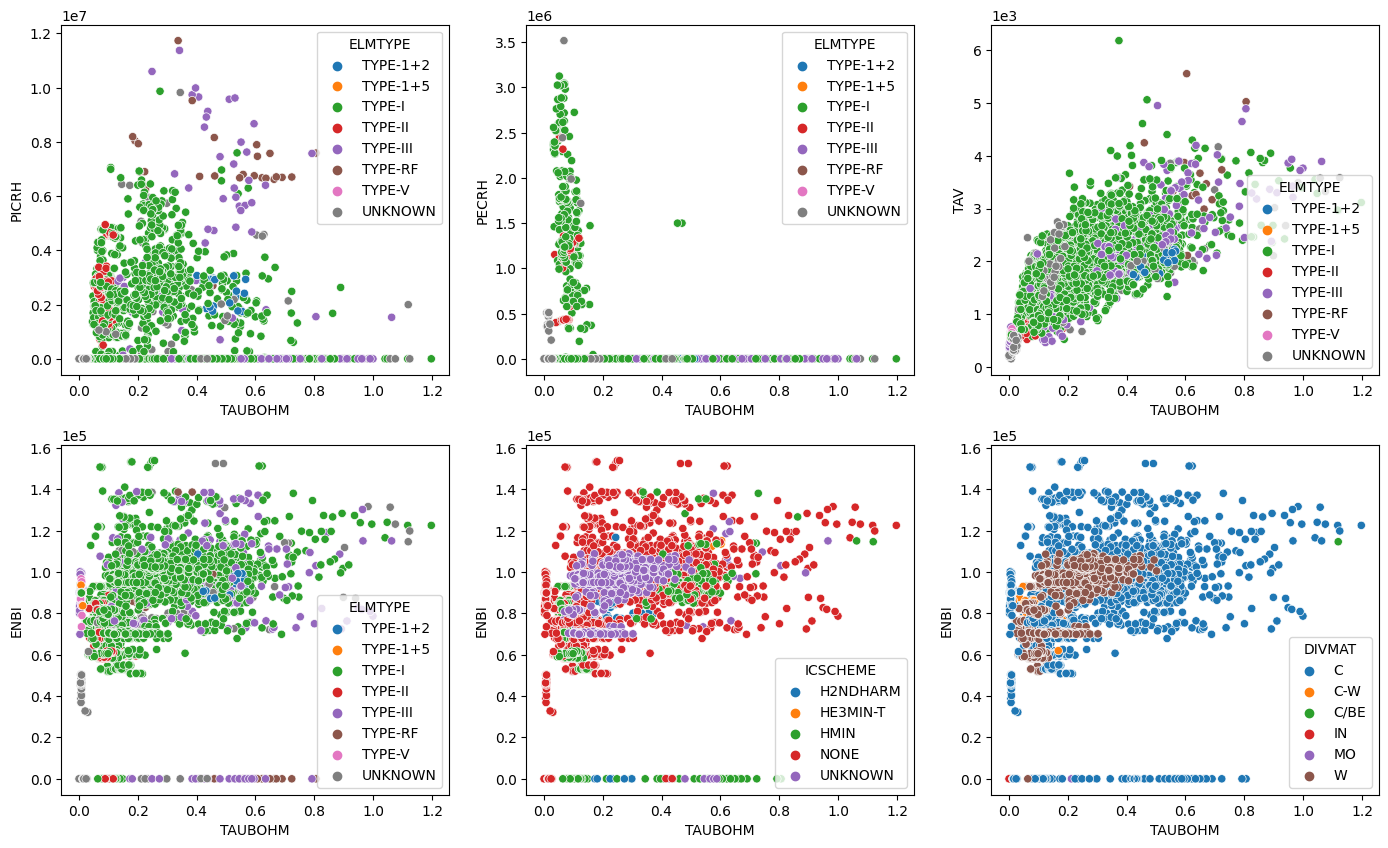

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data2.copy()

sns.scatterplot(data=data_, x="TAUBOHM", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUBOHM", y="PECRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUBOHM", y="TAV", hue="ELMTYPE" ,hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUBOHM", y="ENBI",hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUBOHM", y="ENBI",hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUBOHM", y="ENBI",hue="DIVMAT" ,hue_order=hue_order_DIVMAT, ax=axs[1,2]);

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));



# <center>Electrons and Fast Ions</center>

Both Entropy Analysis and RF point there is interesting information in fast particles

**VARIABLES**
* `NESOL`: Electron density in scrape-off layer.
* `WFFORM`: Total fast ion energy due to NBI estimated from approximate formula.
* `WFICFORM`:  Total fast ion energy due to ICRH estimated from approximate formula.

In [13]:
fast_particles = ["NESOL","WFFORM","WFICFORM"] 

### Group 1 | New points in DB5 that are decreasing alpha-R | $\alpha_R \sim 0.6$



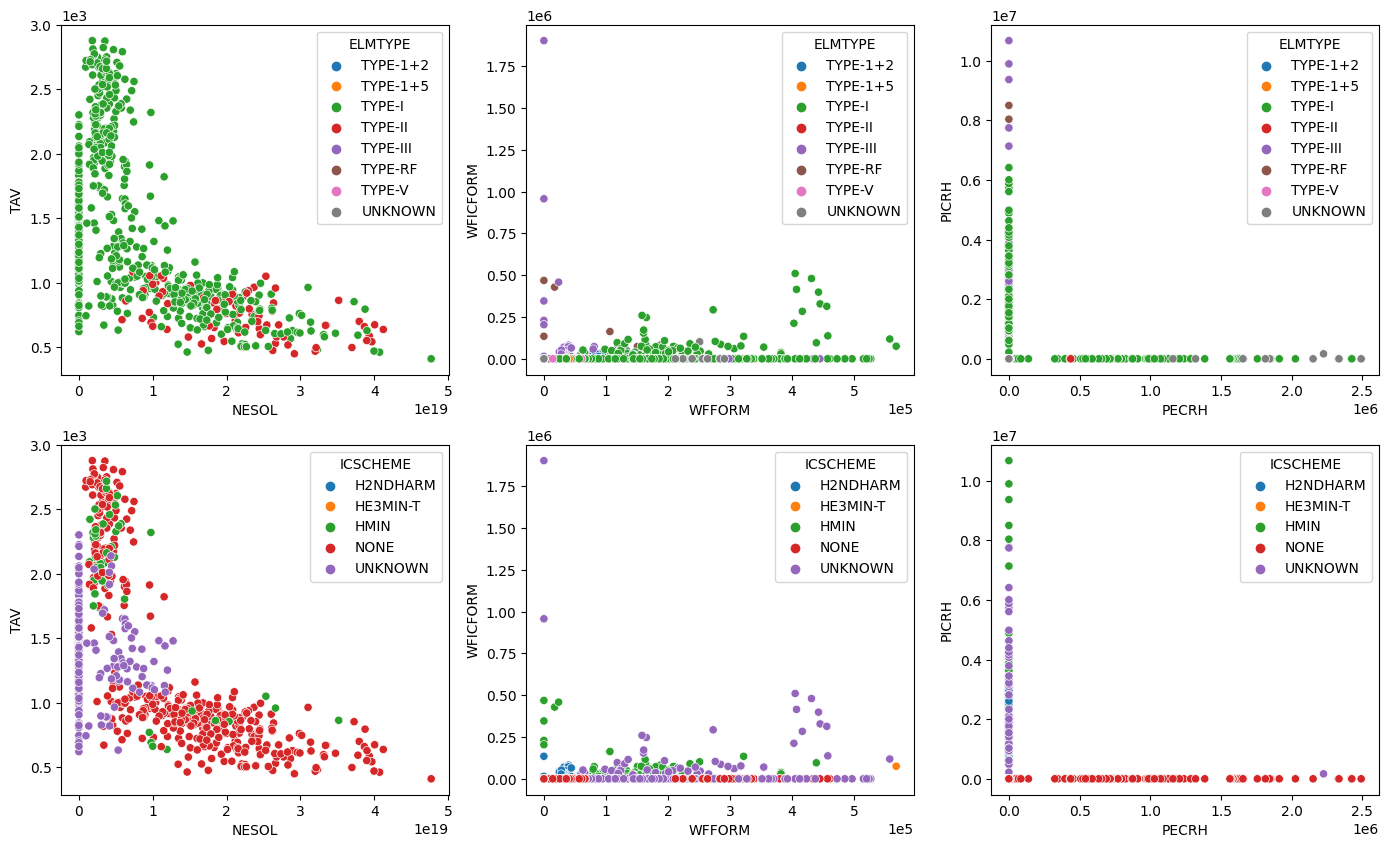

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data1.copy()

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,2])

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));

### Group 2 |  $\alpha_R \sim 2$


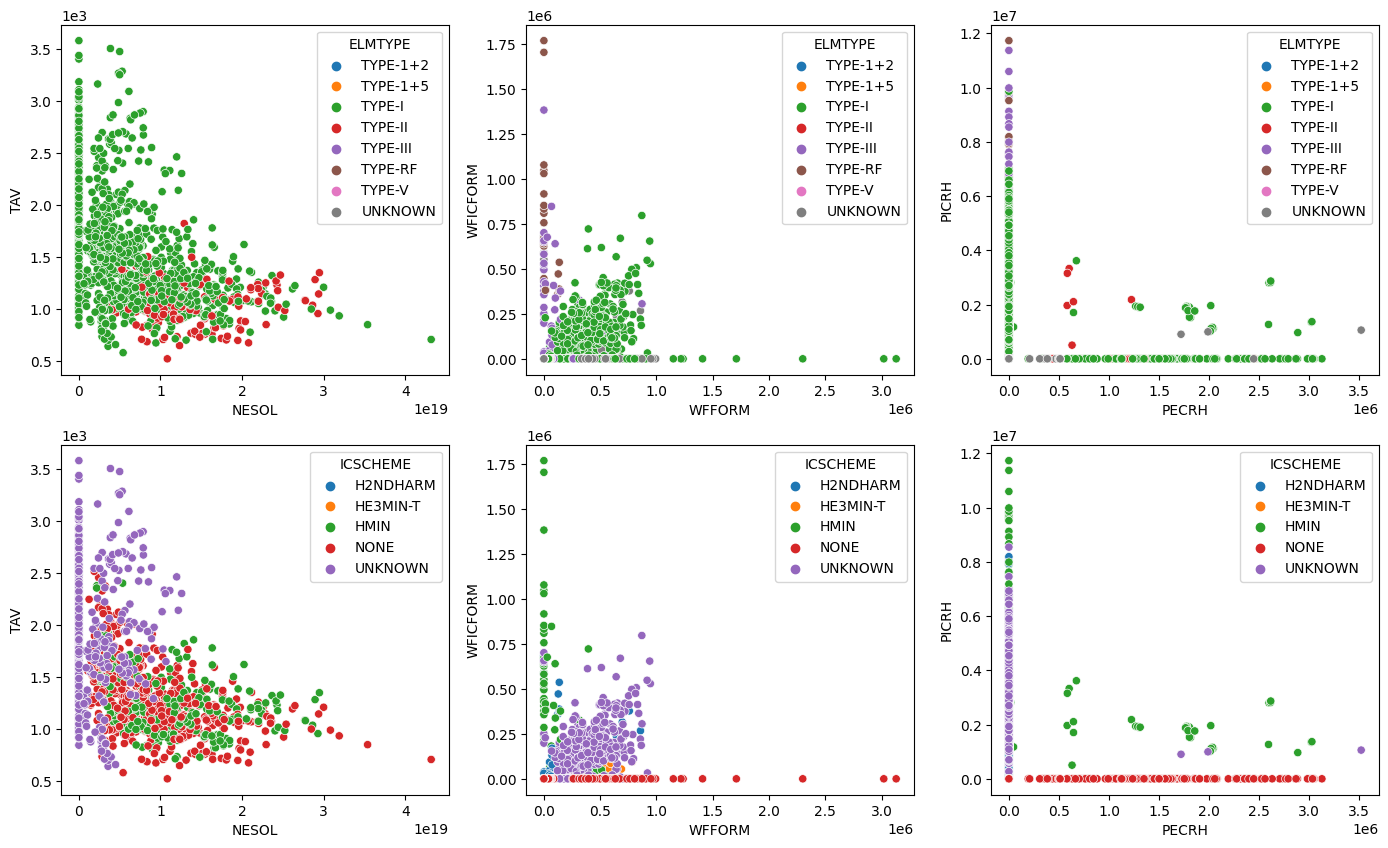

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data2.copy()

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,2])

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));

# <center>Plasma Properties</center>

**VARIABLES**
* `QCYL5`: Cylindrical, the plasma safety factor at the 95% poloidal flux surface. .
* `BEIMHD`: Beta Shafranov. 
* `PREMAG`: Indicates if startup was done with or without pre-magnetization current.
* `LHTIME`: The time of the L to H transition.
* `HYBRID`: Flag for indicating whether the time point is a HYBRID mode.
* `CONFIG`: The plasma configuration.
* `DWDIA`: Time rate of change of the total plasma stored energy.
* `WMHD`: Total plasma energy as determined by MHD equilibrium calculations
* `TORQ`:  Torque on plasma due to neutral beam injection from formula.

In [16]:
plasma_characteristics = ["QCYL5","BEIMHD","PREMAG","LHTIME","HYBRID",
                          "CONFIG","DWDIA","WMHD","TORQ"] 

### Group 1 | New points in DB5 that are decreasing alpha-R | $\alpha_R \sim 0.6$


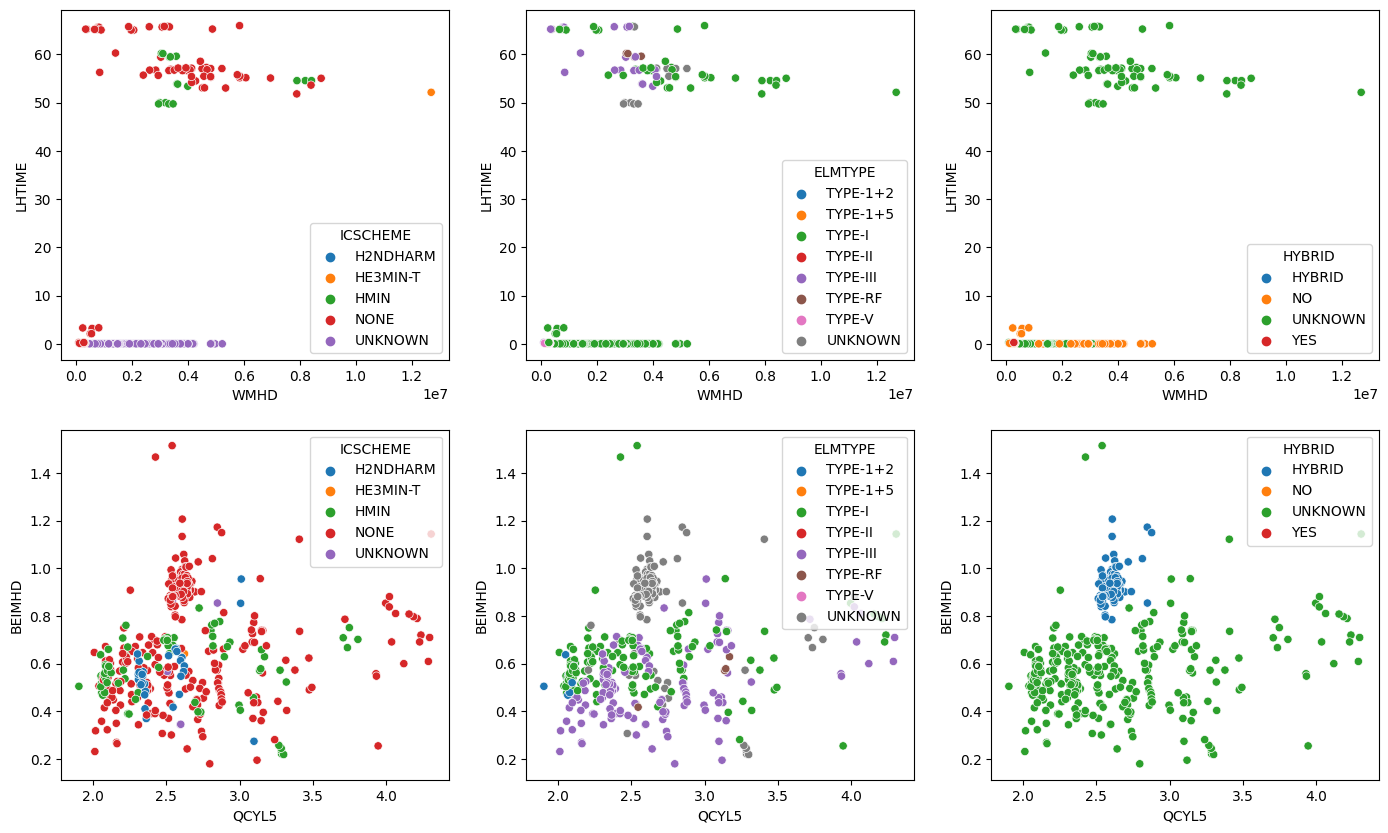

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data1.copy()

sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0,0])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[0,2])

sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1,1])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[1,2]);

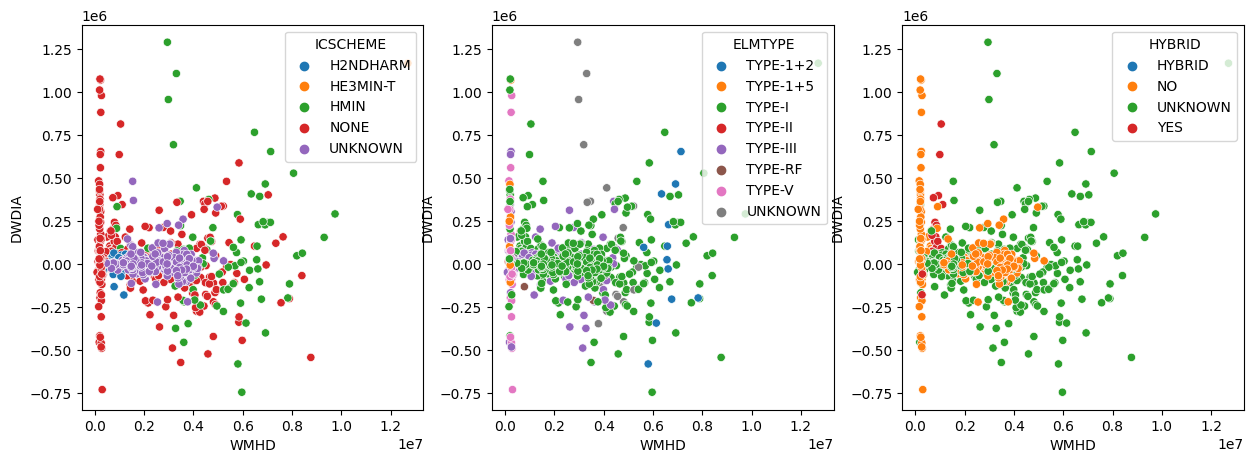

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

data_ = data1.copy()

sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[2]);

### Group 2 |  $\alpha_R \sim 2$


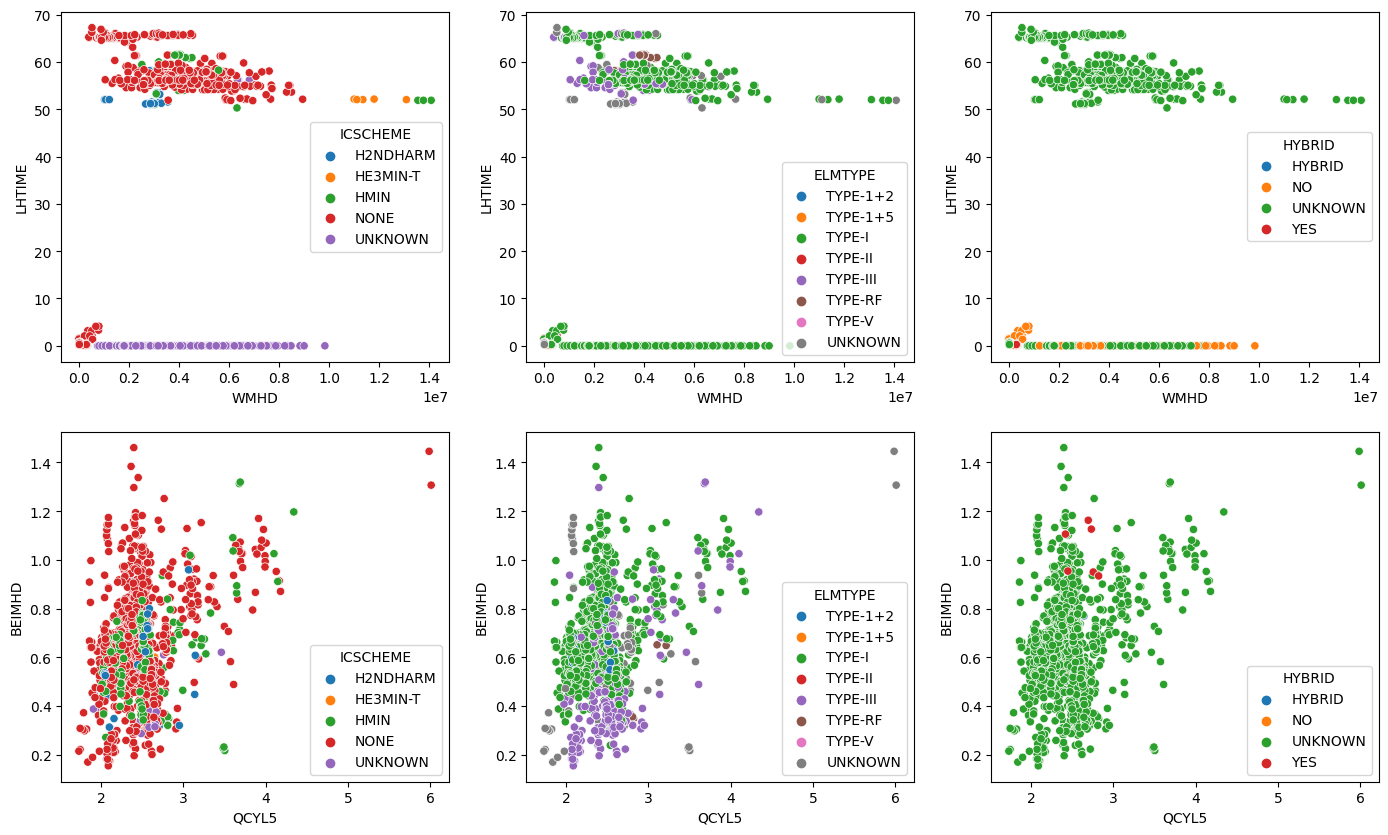

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data2.copy()

sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0,0])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[0,2])

sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1,1])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[1,2]);

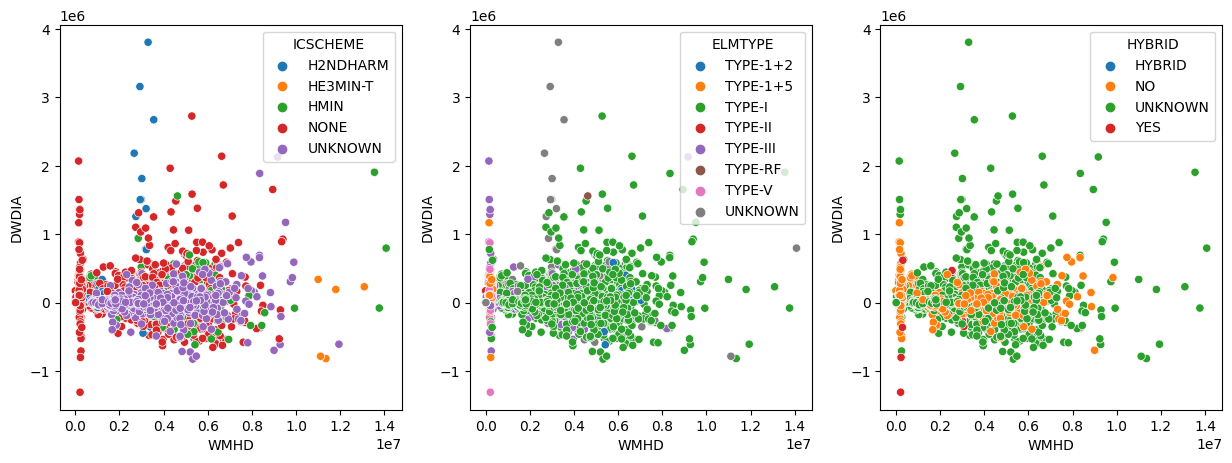

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

data_ = data2.copy()

sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[2]);

# <center>Contamination and Materials</center>

**IMPURITIES VARIABLES**

* `EVAP`: The evaporated material used to cover the inside of the vessel. 
* `ZEFF`: Line average plasma effective charge determined from visible Bremsstrahlung.
* `ZEFFNEO`: Plasma effective charge as determined by neo-classical resistivity.
* `PRAD`: Total radiated power as measured by Bolometer. 

**TOKAMAK VARIABLES**

* `TOK`:  This variable designates which tokamak has supplied the data.
* `DIVNAME`: Describes each device's divertor configuration.
* `WALMAT`:  The material of the vessel wall.
* `DIVMAT`: The material of the divertor tiles.
* `LIMMAT`: The material of the limiters.

In [21]:
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD","ENBI"]
TOK_characteristics = ["TOK","DIVNAME","WALMAT","DIVMAT","LIMMAT"]

### Group 1 | New points in DB5 that are decreasing alpha-R | $\alpha_R \sim 0.6$


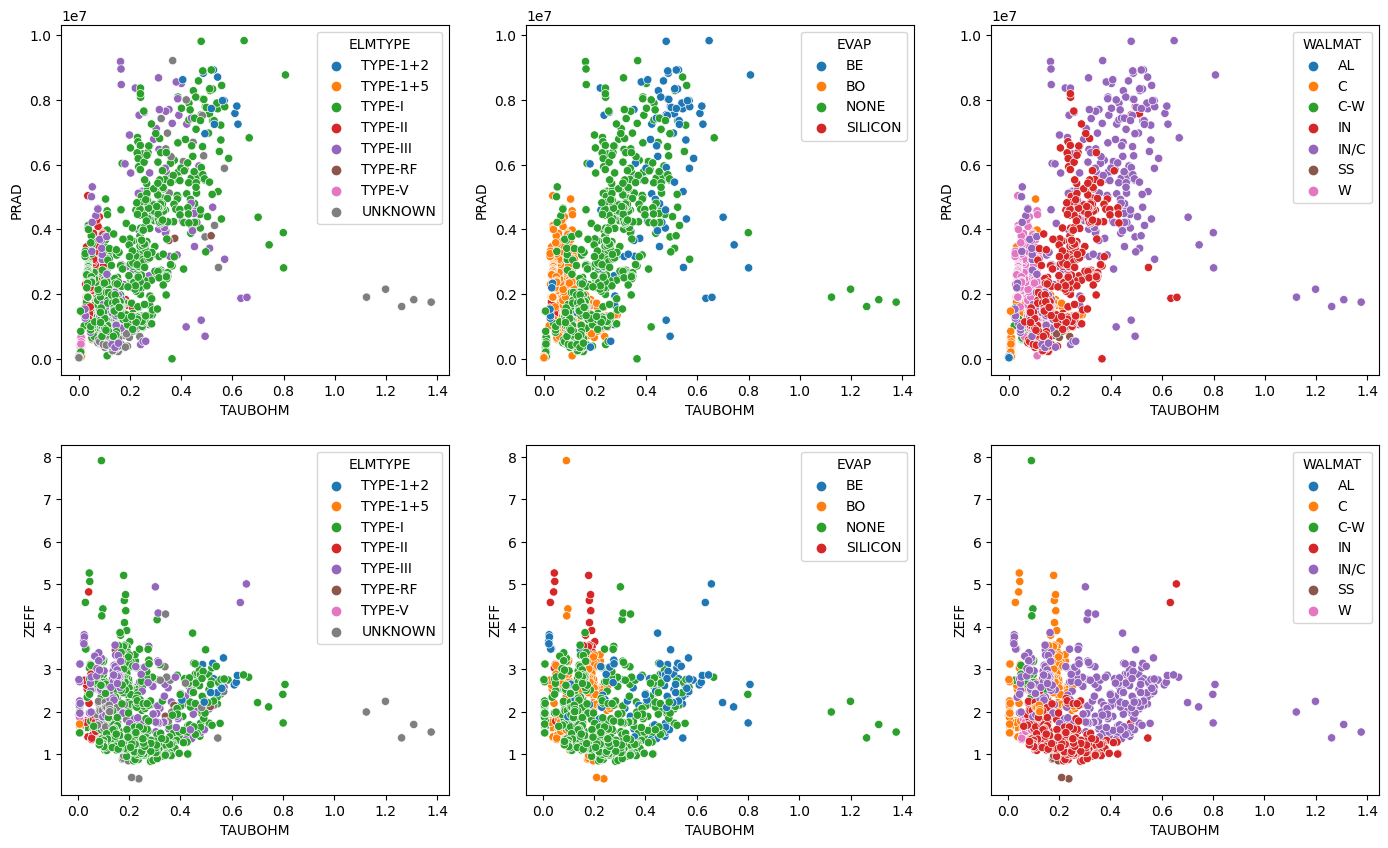

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data1.copy()

sns.scatterplot(data=data_, x="TAUBOHM", y="PRAD", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUBOHM", y="PRAD", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUBOHM", y="PRAD", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUBOHM", y="ZEFF", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUBOHM", y="ZEFF", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUBOHM", y="ZEFF", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[1,2]);

### Group 2 |  $\alpha_R \sim 2$

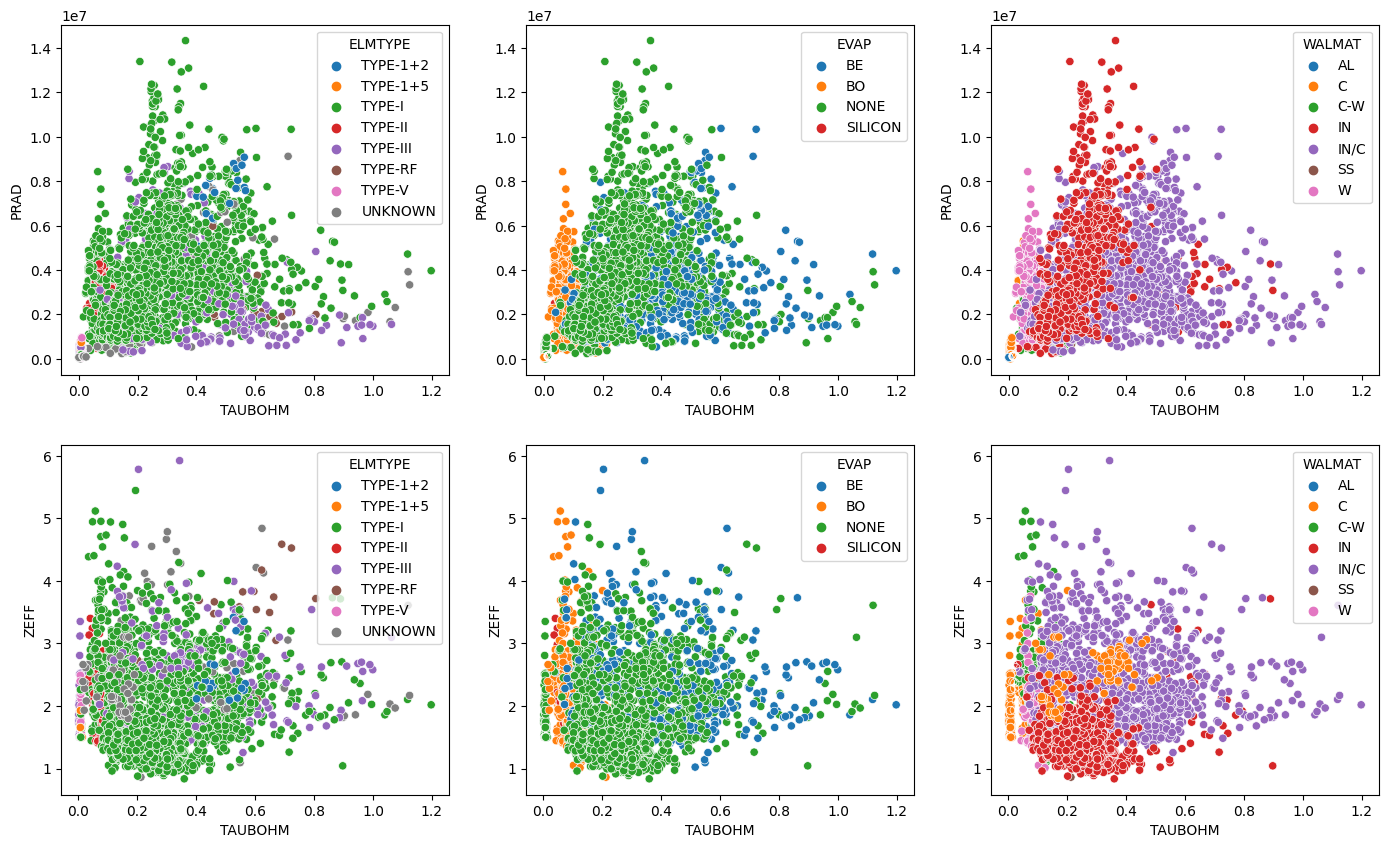

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data2.copy()

sns.scatterplot(data=data_, x="TAUBOHM", y="PRAD", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUBOHM", y="PRAD", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUBOHM", y="PRAD", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUBOHM", y="ZEFF", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUBOHM", y="ZEFF", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUBOHM", y="ZEFF", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[1,2]);

# <center>Power</center>

**VARIABLES**

* `POHM`: Total Ohmic power. 